In [1]:
import itertools as it
import os

from cliffs_delta import cliffs_delta
from iterpop import iterpop as ip
from matplotlib import pyplot as plt
from nbmetalog import nbmetalog as nbm
import numpy as np
import pandas as pd
from scipy import stats as scipy_stats
import seaborn as sns
from teeplot import teeplot as tp

from pylib import describe_effect


In [2]:
# prints metadata about notebook runtime
nbm.print_metadata()


context: ci
hostname: fv-az1020-953
interpreter: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
nbcellexec: null
nbname: perfect-tree-phylometrics
nbpath: /home/runner/work/hstrat-evolutionary-inference/hstrat-evolutionary-inference/binder/avida/perfect-tree-phylometrics.ipynb
revision: null
session: 60d80e62-ae87-4d40-b939-632f8c40f6dd
timestamp: 2024-03-23T21:27:43Z00:00


IPython==8.13.0
keyname==0.5.2
yaml==6.0
iterpop==0.4.1
matplotlib==3.7.1
nbmetalog==0.2.6
numpy==1.21.6
pandas==1.3.5
scipy==1.7.3
seaborn==0.12.1
teeplot==1.0.1
re==2.2.1
comm==0.2.2
logging==0.5.1.2
psutil==5.9.8
zmq==24.0.1
json==2.0.9
ipykernel==6.29.3


In [3]:
df = pd.read_csv("https://osf.io/r29ym/download")
dfdigest = np.bitwise_xor.reduce(
    pd.util.hash_pandas_object(df),
)
print("{:x}".format(dfdigest))
df


c4a6688ae890817b


,a,epoch,mut_distn,treatment,seed,phylogeny-snapshot-100000.csv,_,colless_like_index,average_depth,average_origin_time,...,variance_pairwise_distance,variance_pairwise_distance_branch_only,mrca_depth,sackin_index,mean_evolutionary_distinctiveness,sum_evolutionary_distinctiveness,variance_evolutionary_distinctiveness,subsampling-fraction,trie-postprocess,ext
0,collapsed-phylogeny,0,default,spatial_plain,285,NaN,/mnt/home/mmore500/scratch/data/hstrat-evoluti...,5926.098427,inf,84179.314332,...,1.659114e+05,17.528400,1924,22823,144.974328,316333.983563,7135.200693,NaN,NaN,NaN
1,collapsed-phylogeny,0,default,ecology_rich,33,NaN,/mnt/home/mmore500/scratch/data/hstrat-evoluti...,10543.308321,inf,88309.619155,...,5.642608e+05,29.418707,808,33964,195.984163,537584.557873,15080.442755,NaN,NaN,NaN
2,collapsed-phylogeny,0,default,selection_strong,134,NaN,/mnt/home/mmore500/scratch/data/hstrat-evoluti...,11396.501006,inf,88690.314255,...,7.810827e+03,28.284046,2129,35801,119.564381,342432.387297,7900.355343,NaN,NaN,NaN
3,collapsed-phylogeny,0,default,spatial_ecology_rich,187,NaN,/mnt/home/mmore500/scratch/data/hstrat-evoluti...,9234.057184,inf,82468.509778,...,1.710304e+06,22.145263,369,33834,310.265704,899770.540730,28829.404468,NaN,NaN,NaN
4,collapsed-phylogeny,0,default,spatial_plain,294,NaN,/mnt/home/mmore500/scratch/data/hstrat-evoluti...,4768.904055,inf,75041.078479,...,1.904554e+03,16.768323,2109,15925,109.035642,176528.705163,11930.297151,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,reconstructed-tree,0,default,spatial_ecology_weak,263,NaN,/mnt/home/mmore500/scratch/data/hstrat-evoluti...,9285.949798,20.026093,99869.493162,...,2.035687e+01,20.356872,1,19460,184.833007,283349.000000,15979.575234,1.0,naive,.csv.gz
1496,reconstructed-tree,0,default,selection_weak,154,NaN,/mnt/home/mmore500/scratch/data/hstrat-evoluti...,11563.845652,20.759676,99891.297172,...,2.230634e+01,22.306339,1,22477,161.257366,279136.500000,10477.952430,1.0,naive,.csv.gz
1497,reconstructed-tree,0,default,plain,16,NaN,/mnt/home/mmore500/scratch/data/hstrat-evoluti...,9159.786185,18.497247,99891.350661,...,1.817230e+01,18.172297,1,20469,168.551211,306089.000000,9983.297787,1.0,naive,.csv.gz
1498,reconstructed-tree,0,default,spatial_ecology_rich,195,NaN,/mnt/home/mmore500/scratch/data/hstrat-evoluti...,7775.489944,15.731431,99790.826154,...,1.685180e+01,16.851802,0,21343,485.414904,986848.500000,37193.321937,1.0,naive,.csv.gz


In [4]:
# phylometrics whittled down to descriptive, non-redundant set
df["colless-like index"] = df["colless_like_index"]
df["mean pairwise distance"] = df["mean_pairwise_distance"]
df["sum distance"] = df["sum_distance"]
df["mean evolutionary distinctiveness"] = df[
    "mean_evolutionary_distinctiveness"
]

phylometrics = [
    #     'diversity',
    "colless-like index",
    #     'average_depth',
    #     'average_origin_time',
    #     'average_origin_time_normalized',
    #     'max_depth',
    "mean pairwise distance",
    #     'mean_pairwise_distance_branch_only',
    #     'num_active',
    "sum distance",
    # "num_ancestors",
    #     'num_outside',
    #     'num_roots',
    #     'num_taxa',
    #     'phylogenetic_diversity',
    #     'sum_pairwise_distance',
    #     'sum_pairwise_distance_branch_only',
    #     'total_orgs',
    #     'tree_size',
    #     'variance_pairwise_distance',
    #     'variance_pairwise_distance_branch_only',
    #     'mrca_depth',
    #     'sackin_index',
    "mean evolutionary distinctiveness",
    #     'sum_evolutionary_distinctiveness',
    #     'variance_evolutionary_distinctiveness',
]


In [5]:
methodological_variables = [
    "resolution",
]


In [6]:
evolutionary_variables = [
    "num_islands",
    "num_niches",
    "tournament_size",
    "p_niche_invasion",
]


In [7]:
sensitivity_analysis_variables = [
    "epoch",
    "mut_distn",
]


In [8]:
fixed_variables = [
    "subsampling-fraction",  # only use 1.0
    "trie-postprocess",  # just use naive postprocessing for now
]


In [9]:
# ensure fixed variables
df = df[
    ((df["subsampling-fraction"] == 1.0) | df["subsampling-fraction"].isna())
    & ((df["trie-postprocess"] == "naive") | df["trie-postprocess"].isna())
].copy()

for fixed_variable in fixed_variables:
    assert len(df[fixed_variable].dropna().unique()) == 1

df


,a,epoch,mut_distn,treatment,seed,phylogeny-snapshot-100000.csv,_,colless_like_index,average_depth,average_origin_time,...,mean_evolutionary_distinctiveness,sum_evolutionary_distinctiveness,variance_evolutionary_distinctiveness,subsampling-fraction,trie-postprocess,ext,colless-like index,mean pairwise distance,sum distance,mean evolutionary distinctiveness
0,collapsed-phylogeny,0,default,spatial_plain,285,NaN,/mnt/home/mmore500/scratch/data/hstrat-evoluti...,5926.098427,inf,84179.314332,...,144.974328,316333.983563,7135.200693,NaN,NaN,NaN,5926.098427,613.959834,375700.0,144.974328
1,collapsed-phylogeny,0,default,ecology_rich,33,NaN,/mnt/home/mmore500/scratch/data/hstrat-evoluti...,10543.308321,inf,88309.619155,...,195.984163,537584.557873,15080.442755,NaN,NaN,NaN,10543.308321,849.326781,546002.0,195.984163
2,collapsed-phylogeny,0,default,selection_strong,134,NaN,/mnt/home/mmore500/scratch/data/hstrat-evoluti...,11396.501006,inf,88690.314255,...,119.564381,342432.387297,7900.355343,NaN,NaN,NaN,11396.501006,205.738863,403064.0,119.564381
3,collapsed-phylogeny,0,default,spatial_ecology_rich,187,NaN,/mnt/home/mmore500/scratch/data/hstrat-evoluti...,9234.057184,inf,82468.509778,...,310.265704,899770.540730,28829.404468,NaN,NaN,NaN,9234.057184,2216.393944,864578.0,310.265704
4,collapsed-phylogeny,0,default,spatial_plain,294,NaN,/mnt/home/mmore500/scratch/data/hstrat-evoluti...,4768.904055,inf,75041.078479,...,109.035642,176528.705163,11930.297151,NaN,NaN,NaN,4768.904055,77.017025,263110.0,109.035642
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,reconstructed-tree,0,default,spatial_ecology_weak,263,NaN,/mnt/home/mmore500/scratch/data/hstrat-evoluti...,9285.949798,20.026093,99869.493162,...,184.833007,283349.000000,15979.575234,1.0,naive,.csv.gz,9285.949798,18.679044,359912.5,184.833007
1496,reconstructed-tree,0,default,selection_weak,154,NaN,/mnt/home/mmore500/scratch/data/hstrat-evoluti...,11563.845652,20.759676,99891.297172,...,161.257366,279136.500000,10477.952430,1.0,naive,.csv.gz,11563.845652,18.988225,355733.0,161.257366
1497,reconstructed-tree,0,default,plain,16,NaN,/mnt/home/mmore500/scratch/data/hstrat-evoluti...,9159.786185,18.497247,99891.350661,...,168.551211,306089.000000,9983.297787,1.0,naive,.csv.gz,9159.786185,17.945560,379823.5,168.551211
1498,reconstructed-tree,0,default,spatial_ecology_rich,195,NaN,/mnt/home/mmore500/scratch/data/hstrat-evoluti...,7775.489944,15.731431,99790.826154,...,485.414904,986848.500000,37193.321937,1.0,naive,.csv.gz,7775.489944,19.082603,954352.5,485.414904


In [10]:
# exclude extraneous variable values
df = df[(df["a"] == "collapsed-phylogeny")].copy()

df


,a,epoch,mut_distn,treatment,seed,phylogeny-snapshot-100000.csv,_,colless_like_index,average_depth,average_origin_time,...,mean_evolutionary_distinctiveness,sum_evolutionary_distinctiveness,variance_evolutionary_distinctiveness,subsampling-fraction,trie-postprocess,ext,colless-like index,mean pairwise distance,sum distance,mean evolutionary distinctiveness
0,collapsed-phylogeny,0,default,spatial_plain,285,NaN,/mnt/home/mmore500/scratch/data/hstrat-evoluti...,5926.098427,inf,84179.314332,...,144.974328,316333.983563,7135.200693,NaN,NaN,NaN,5926.098427,613.959834,375700.0,144.974328
1,collapsed-phylogeny,0,default,ecology_rich,33,NaN,/mnt/home/mmore500/scratch/data/hstrat-evoluti...,10543.308321,inf,88309.619155,...,195.984163,537584.557873,15080.442755,NaN,NaN,NaN,10543.308321,849.326781,546002.0,195.984163
2,collapsed-phylogeny,0,default,selection_strong,134,NaN,/mnt/home/mmore500/scratch/data/hstrat-evoluti...,11396.501006,inf,88690.314255,...,119.564381,342432.387297,7900.355343,NaN,NaN,NaN,11396.501006,205.738863,403064.0,119.564381
3,collapsed-phylogeny,0,default,spatial_ecology_rich,187,NaN,/mnt/home/mmore500/scratch/data/hstrat-evoluti...,9234.057184,inf,82468.509778,...,310.265704,899770.540730,28829.404468,NaN,NaN,NaN,9234.057184,2216.393944,864578.0,310.265704
4,collapsed-phylogeny,0,default,spatial_plain,294,NaN,/mnt/home/mmore500/scratch/data/hstrat-evoluti...,4768.904055,inf,75041.078479,...,109.035642,176528.705163,11930.297151,NaN,NaN,NaN,4768.904055,77.017025,263110.0,109.035642
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,collapsed-phylogeny,0,default,spatial_plain,292,NaN,/mnt/home/mmore500/scratch/data/hstrat-evoluti...,6013.394596,inf,83975.595642,...,91.640177,202524.790908,2142.927656,NaN,NaN,NaN,6013.394596,162.981803,284830.0,91.640177
296,collapsed-phylogeny,0,default,spatial_ecology_weak,253,NaN,/mnt/home/mmore500/scratch/data/hstrat-evoluti...,7232.904813,inf,88789.867980,...,188.080486,503303.381142,14295.668987,NaN,NaN,NaN,7232.904813,974.709137,546648.0,188.080486
297,collapsed-phylogeny,0,default,spatial_ecology_weak,251,NaN,/mnt/home/mmore500/scratch/data/hstrat-evoluti...,12407.798625,inf,90326.236522,...,247.302230,760207.054828,18280.013842,NaN,NaN,NaN,12407.798625,909.713722,762456.0,247.302230
298,collapsed-phylogeny,0,default,selection_weak,176,NaN,/mnt/home/mmore500/scratch/data/hstrat-evoluti...,11405.621379,inf,86657.794854,...,110.514118,291646.757860,6060.545552,NaN,NaN,NaN,11405.621379,139.664976,359234.0,110.514118


In [11]:
df["a"].unique()


array(['collapsed-phylogeny'], dtype=object)

In [12]:
df["regime"] = df["treatment"].map(
    {
        "plain": "plain",
        "selection_weak": "weak selection",
        "selection_strong": "strong selection",
        "spatial_plain": "spatial structure",
        "ecology_some": "ecology",
        "ecology_rich": "rich ecology",
        "spatial_ecology_rich": "rich ecology, spatial",
        "spatial_ecology_some": "ecology, spatial",
        "ecology_weak": "weak ecology",
        "spatial_ecology_weak": "weak ecology, spatial",
    },
)
df["regime"].unique()


array(['spatial structure', 'rich ecology', 'strong selection',
       'rich ecology, spatial', 'plain', 'ecology, spatial',
       'weak ecology', 'weak ecology, spatial', 'ecology',
       'weak selection'], dtype=object)

In [13]:
df[df["a"] == "collapsed-phylogeny"]["regime"].unique()


array(['spatial structure', 'rich ecology', 'strong selection',
       'rich ecology, spatial', 'plain', 'ecology, spatial',
       'weak ecology', 'weak ecology, spatial', 'ecology',
       'weak selection'], dtype=object)

# Phylometrics by Regime, Perfect Data


In [14]:
melted_df = df[(df["a"] == "collapsed-phylogeny")].melt(
    id_vars=(
        # evolutionary_variables
        # methodological_variables
        sensitivity_analysis_variables
        + ["regime"]
    ),
    value_vars=phylometrics,
)
melted_df["phylometric"] = melted_df["variable"]
melted_df


,epoch,mut_distn,regime,variable,value,phylometric
0,0,default,spatial structure,colless-like index,5926.098427,colless-like index
1,0,default,rich ecology,colless-like index,10543.308321,colless-like index
2,0,default,strong selection,colless-like index,11396.501006,colless-like index
3,0,default,"rich ecology, spatial",colless-like index,9234.057184,colless-like index
4,0,default,spatial structure,colless-like index,4768.904055,colless-like index
...,...,...,...,...,...,...
1195,0,default,spatial structure,mean evolutionary distinctiveness,91.640177,mean evolutionary distinctiveness
1196,0,default,"weak ecology, spatial",mean evolutionary distinctiveness,188.080486,mean evolutionary distinctiveness
1197,0,default,"weak ecology, spatial",mean evolutionary distinctiveness,247.302230,mean evolutionary distinctiveness
1198,0,default,weak selection,mean evolutionary distinctiveness,110.514118,mean evolutionary distinctiveness


teeplots/col=phylometric+epoch=0+mut_distn=default+viz=barplot+x=value+y=regime+ext=.pdf


teeplots/col=phylometric+epoch=0+mut_distn=default+viz=barplot+x=value+y=regime+ext=.png


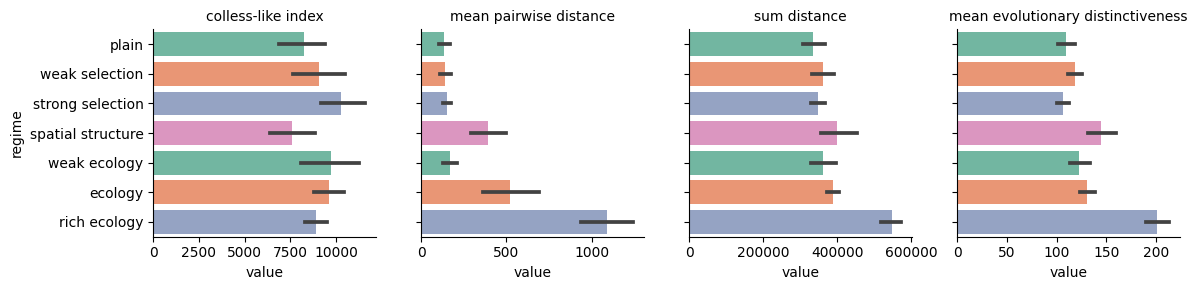

teeplots/col=phylometric+epoch=0+mut_distn=default+viz=boxplot+x=value+y=regime+ext=.pdf


teeplots/col=phylometric+epoch=0+mut_distn=default+viz=boxplot+x=value+y=regime+ext=.png


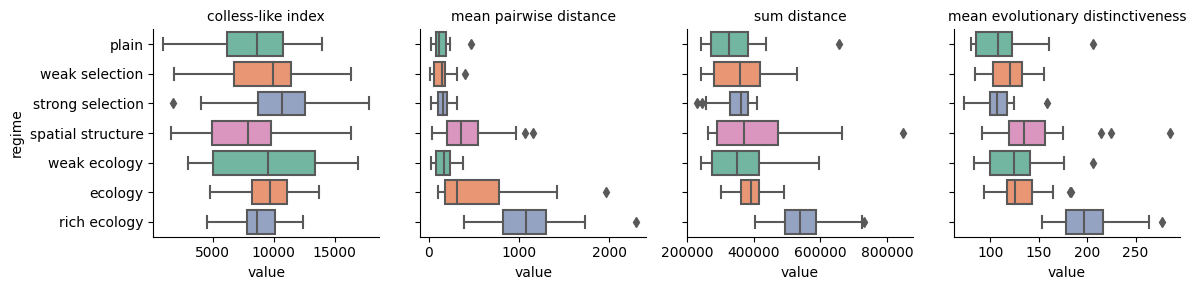

teeplots/col=phylometric+epoch=0+mut_distn=default+viz=violinplot+x=value+y=regime+ext=.pdf


teeplots/col=phylometric+epoch=0+mut_distn=default+viz=violinplot+x=value+y=regime+ext=.png


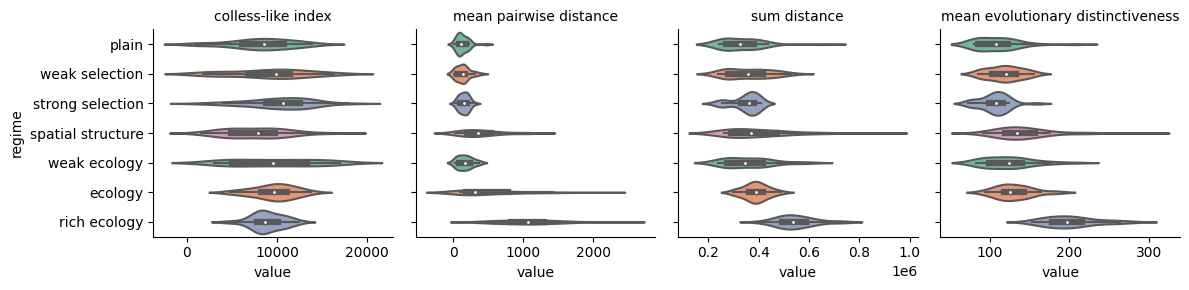

In [15]:
def make_do_plot(plotter):
    def do_plot(data, col, x, y):
        g = sns.FacetGrid(
            data,
            col=col,
            sharex=False,
        ).set_titles(template="{col_name}")
        g.map(
            plotter,
            x,
            y,
            order=[
                "plain",
                "weak selection",
                "strong selection",
                "spatial structure",
                "weak ecology",
                "ecology",
                "rich ecology",
            ],
            palette=sns.color_palette("Set2", 4),
        )

    return do_plot


for viz, (group, group_df) in it.product(
    [
        sns.barplot,
        sns.boxplot,
        sns.violinplot,
    ],
    melted_df.groupby(sensitivity_analysis_variables),
):
    do_plot = make_do_plot(viz)
    do_plot.__name__ = viz.__name__
    tp.tee(
        do_plot,
        data=group_df,
        col="phylometric",
        x="value",
        y="regime",
        teeplot_outattrs=dict(
            zip(sensitivity_analysis_variables, group),
        ),
    )


## With space


teeplots/col=phylometric+epoch=0+mut_distn=default+spatial=true+viz=barplot+x=value+y=regime+ext=.pdf


teeplots/col=phylometric+epoch=0+mut_distn=default+spatial=true+viz=barplot+x=value+y=regime+ext=.png


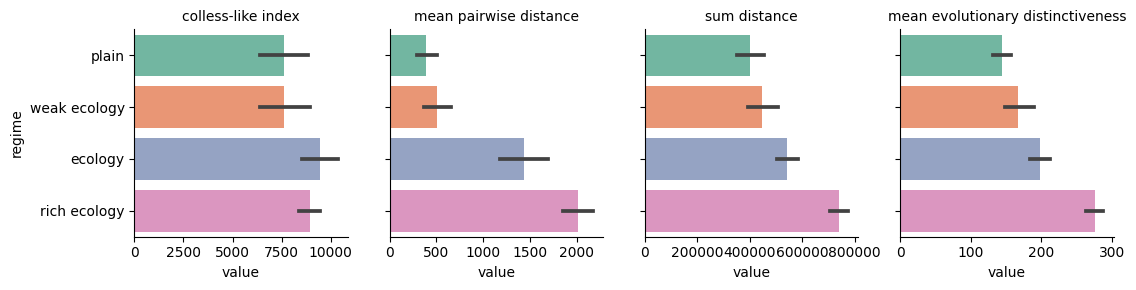

teeplots/col=phylometric+epoch=0+mut_distn=default+spatial=true+viz=boxplot+x=value+y=regime+ext=.pdf


teeplots/col=phylometric+epoch=0+mut_distn=default+spatial=true+viz=boxplot+x=value+y=regime+ext=.png


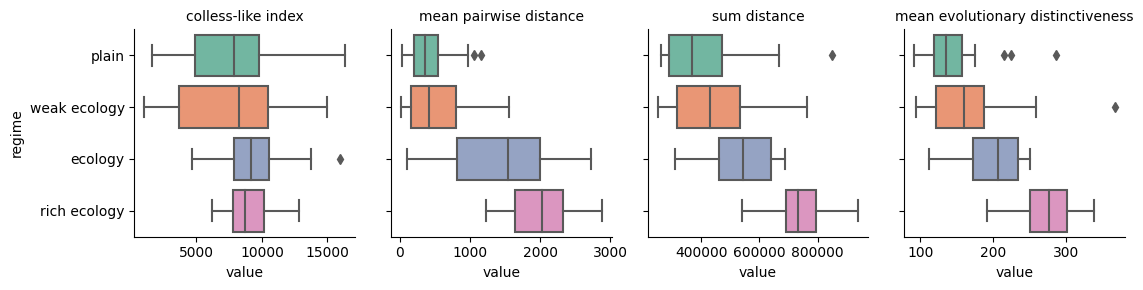

teeplots/col=phylometric+epoch=0+mut_distn=default+spatial=true+viz=violinplot+x=value+y=regime+ext=.pdf


teeplots/col=phylometric+epoch=0+mut_distn=default+spatial=true+viz=violinplot+x=value+y=regime+ext=.png


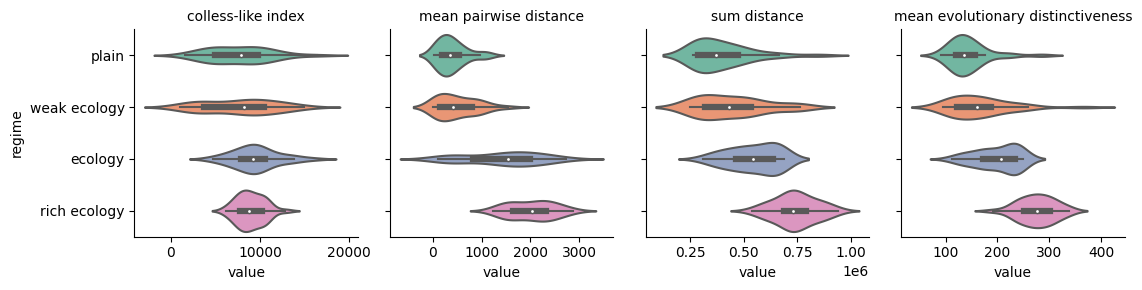

In [16]:
def make_do_plot(plotter):
    def do_plot(data, col, x, y):
        g = sns.FacetGrid(
            data,
            col=col,
            sharex=False,
        ).set_titles(template="{col_name}")
        g.map(
            plotter,
            x,
            y,
            order=[
                "spatial structure",
                "weak ecology, spatial",
                "ecology, spatial",
                "rich ecology, spatial",
            ],
            palette=sns.color_palette("Set2", 4),
        )
        g.set(
            yticklabels=[
                "plain",
                "weak ecology",
                "ecology",
                "rich ecology",
            ],
        )

    return do_plot


for viz, (group, group_df) in it.product(
    [
        sns.barplot,
        sns.boxplot,
        sns.violinplot,
    ],
    melted_df.groupby(sensitivity_analysis_variables),
):
    do_plot = make_do_plot(viz)
    do_plot.__name__ = viz.__name__
    tp.tee(
        do_plot,
        data=group_df,
        col="phylometric",
        x="value",
        y="regime",
        teeplot_outattrs={
            "spatial": "true",
            **dict(zip(sensitivity_analysis_variables, group)),
        },
    )


# regime heatmap signatures


teeplots/epoch=0+mut_distn=default+viz=heatmap+x=regime+y=phylometric+ext=.pdf


teeplots/epoch=0+mut_distn=default+viz=heatmap+x=regime+y=phylometric+ext=.png


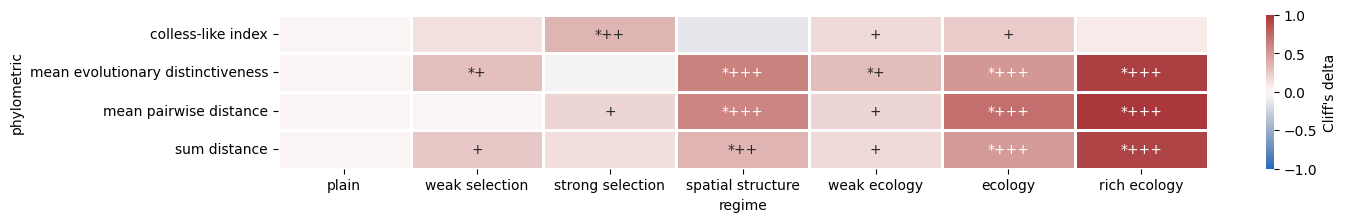

In [17]:
for (group, group_df) in df[
    df["regime"].isin(
        [
            "plain",
            "weak selection",
            "strong selection",
            "spatial structure",
            "weak ecology",
            "ecology",
            "rich ecology",
        ],
    )
].groupby(sensitivity_analysis_variables):

    fil = (
        group_df[(group_df["a"] == "collapsed-phylogeny")]
        .copy()
        .dropna(subset=["regime"])
    )

    melted_df = fil.melt(
        id_vars=["regime"],
        value_vars=phylometrics,
    )
    melted_df["phylometric"] = melted_df["variable"]

    def calc_cliffs_delta(group) -> float:
        phylometric, regime = group.name
        return -cliffs_delta(
            fil[fil["regime"] == "plain"][phylometric],
            fil[fil["regime"] == regime][phylometric],
        )[0]

    melted_df = melted_df.groupby(["phylometric", "regime"]).apply(
        calc_cliffs_delta,
    ).reset_index(name="value")

    fig, ax = plt.subplots(figsize=(15, 2))

    matrix = melted_df.pivot(
        index="phylometric",
        columns="regime",
        values="value",
    )
    matrix = matrix[
        sorted(
            matrix.columns,
            key=[
                "plain",
                "weak selection",
                "strong selection",
                "spatial structure",
                "weak ecology",
                "ecology",
                "rich ecology",
            ].index,
        )
    ]

    annot = []
    for metric, row in matrix.iterrows():

        def getvec(regime: str) -> np.array:
            return fil[fil["regime"] == regime][metric].to_numpy()

        annot.append(
            [
                describe_effect(getvec("plain"), getvec(regime))
                for regime in matrix.columns
            ],
        )

    tp.tee(
        sns.heatmap,
        matrix,
        annot=annot,
        fmt="",
        linewidths=2,
        cmap=sns.color_palette("vlag", as_cmap=True),
        center=0,
        cbar_kws={"label": "Cliff's delta"},
        teeplot_outattrs={
            **dict(
                zip(sensitivity_analysis_variables, group),
            ),
            **{
                "x": "regime",
                "y": "phylometric",
            },
        },
        teeplot_outexclude=["fmt"],
        vmin=-1,
        vmax=1,
    )


## regime heatmap signatures, with space


teeplots/epoch=0+mut_distn=default+spatial=true+viz=heatmap+x=regime+y=phylometric+ext=.pdf


teeplots/epoch=0+mut_distn=default+spatial=true+viz=heatmap+x=regime+y=phylometric+ext=.png


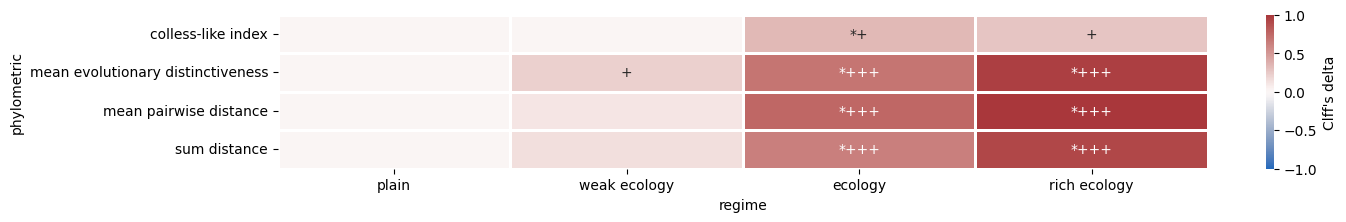

In [18]:
for (group, group_df) in df[
    df["regime"].isin(
        [
            "spatial structure",
            "weak ecology, spatial",
            "ecology, spatial",
            "rich ecology, spatial",
        ],
    )
].groupby(sensitivity_analysis_variables):

    fil = (
        group_df[(group_df["a"] == "collapsed-phylogeny")]
        .copy()
        .dropna(subset=["regime"])
    )
    fil["regime"] = fil["regime"].map(
        {
            "spatial structure": "plain",
            "weak ecology, spatial": "weak ecology",
            "ecology, spatial": "ecology",
            "rich ecology, spatial": "rich ecology",
        }
    )

    melted_df = fil.melt(
        id_vars=["regime"],
        value_vars=phylometrics,
    )
    melted_df["phylometric"] = melted_df["variable"]

    def calc_cliffs_delta(group) -> float:
        phylometric, regime = group.name
        return -cliffs_delta(
            fil[fil["regime"] == "plain"][phylometric],
            fil[fil["regime"] == regime][phylometric],
        )[0]

    melted_df = melted_df.groupby(["phylometric", "regime"]).apply(
        calc_cliffs_delta,
    ).reset_index(name="value")

    fig, ax = plt.subplots(figsize=(15, 2))

    matrix = melted_df.pivot(
        index="phylometric",
        columns="regime",
        values="value",
    )
    matrix = matrix[
        sorted(
            matrix.columns,
            key=[
                "plain",
                "weak ecology",
                "ecology",
                "rich ecology",
            ].index,
        )
    ]

    annot = []
    for metric, row in matrix.iterrows():

        def getvec(regime: str) -> np.array:
            return fil[fil["regime"] == regime][metric].to_numpy()

        annot.append(
            [
                describe_effect(getvec("plain"), getvec(regime))
                for regime in matrix.columns
            ],
        )

    tp.tee(
        sns.heatmap,
        matrix,
        annot=annot,
        fmt="",
        linewidths=2,
        cmap=sns.color_palette("vlag", as_cmap=True),
        center=0,
        cbar_kws={"label": "Clff's delta"},
        teeplot_outattrs={
            **dict(
                zip(sensitivity_analysis_variables, group),
            ),
            **{
                "x": "regime",
                "y": "phylometric",
                "spatial": "true",
            },
        },
        teeplot_outexclude=["fmt"],
        vmin=-1,
        vmax=1,
    )


# stats: kruskal-wallis


In [19]:
records = []
for phylometric in phylometrics:
    for group, group_df in df.groupby(
        sensitivity_analysis_variables, as_index=False
    ):
        kw_result, n = scipy_stats.kruskal(
            *(
                quality_series
                for quality, quality_series in group_df.groupby(["regime"])[
                    phylometric
                ]
            )
        ), ip.pophomogeneous(group_df.groupby(["regime"]).count()["a"])
        records.append(
            {
                **{
                    "n": n,
                    "N": len([*group_df.groupby(["regime"])]),
                    "phylometric": phylometric,
                },
                **dict(zip(["statistic", "p"], kw_result)),
                **dict(zip(sensitivity_analysis_variables, group)),
            }
        )

with pd.option_context("display.max_colwidth", None, "display.max_rows", None):
    out_df = (
        pd.DataFrame.from_records(records)
        .sort_values(
            sensitivity_analysis_variables,
        )
        .reset_index(drop=True)
    )
    display(out_df)
    os.makedirs("outdata", exist_ok=True)
    out_df.to_csv(
        "outdata/a=phylostatistics-comparison-between-regimes-kwallis+ext=.csv",
        index=False,
    )


,n,N,phylometric,statistic,p,epoch,mut_distn
0,30,10,colless-like index,17.397989,4.283626e-02,0,default
1,30,10,mean pairwise distance,193.272558,8.503419e-37,0,default
2,30,10,sum distance,154.237262,1.167122e-28,0,default
3,30,10,mean evolutionary distinctiveness,189.145054,6.214483e-36,0,default


# stats: wilcoxon all pairs


In [20]:
records = []
for phylometric in phylometrics:
    for group, group_df in df.groupby(
        sensitivity_analysis_variables, as_index=False
    ):
        for regime1, regime2 in it.combinations(
            group_df["regime"].unique(), 2
        ):
            kw_result, n = scipy_stats.wilcoxon(
                group_df[group_df["regime"] == regime1][phylometric],
                group_df[group_df["regime"] == regime2][phylometric],
            ), ip.pophomogeneous(group_df.groupby(["regime"]).count()["a"])
            records.append(
                {
                    **{
                        "regime1": regime1,
                        "regime2": regime2,
                        "n": n,
                        "phylometric": phylometric,
                    },
                    **dict(zip(["statistic", "p"], kw_result)),
                    **dict(zip(sensitivity_analysis_variables, group)),
                }
            )

with pd.option_context("display.max_colwidth", None, "display.max_rows", None):
    out_df = (
        pd.DataFrame.from_records(records)
        .sort_values(
            [*sensitivity_analysis_variables, "regime1", "regime2"],
        )
        .reset_index(drop=True)
    )
    display(out_df)
    os.makedirs("outdata", exist_ok=True)
    out_df.to_csv(
        "outdata/a=phylostatistics-comparison-between-regimes-allpairs-wilcox+ext=.csv",
        index=False,
    )


,regime1,regime2,n,phylometric,statistic,p,epoch,mut_distn
0,ecology,weak selection,30,colless-like index,226.0,0.893644,0,default
1,ecology,weak selection,30,mean pairwise distance,57.0,0.000306,0,default
2,ecology,weak selection,30,sum distance,145.0,0.071903,0,default
3,ecology,weak selection,30,mean evolutionary distinctiveness,137.0,0.049498,0,default
4,"ecology, spatial",ecology,30,colless-like index,220.0,0.797098,0,default
5,"ecology, spatial",ecology,30,mean pairwise distance,32.0,0.000037,0,default
6,"ecology, spatial",ecology,30,sum distance,14.0,0.000007,0,default
7,"ecology, spatial",ecology,30,mean evolutionary distinctiveness,5.0,0.000003,0,default
8,"ecology, spatial",weak ecology,30,colless-like index,231.0,0.975387,0,default
9,"ecology, spatial",weak ecology,30,mean pairwise distance,5.0,0.000003,0,default
